# Modeling

Goal: compare persistence baseline, Ridge regression, and RandomForest models on the processed UCI bike-sharing hour dataset. We'll load the prepared data, respect temporal ordering in splits, evaluate each model on RMSE/MAE/MAPE, and visualize results + feature importances.

## Imports & Paths

In [10]:
from __future__ import annotations

import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
# Set up paths relative to project root
ROOT = Path.cwd().parent
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_DIR = ROOT / "results"
MODELS_DIR = ROOT / "models"

RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

DATA_PATH

WindowsPath('C:/Users/ericb/source/bike_forecast/data/processed_hour.csv')

In [12]:
from pathlib import Path
import matplotlib.pyplot as plt

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def save_plot(fig, filename, tight=True):
    """Standardize figure saving under results/."""
    if tight:
        fig.tight_layout()
    out_path = RESULTS_DIR / filename
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"Saved plot to {out_path}")

## Load prepared data
- Uses `src/prepare.py` output (`data/processed_hour.csv`)
- Ensures datetime column parsed, sorted chronologically

In [13]:
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.rename(columns={"timestamp": "datetime"})
df = df.sort_values("datetime").reset_index(drop=True)

print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
df.head()

Rows: 17,520 | Columns: 34


,datetime,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,dayofweek_sin,dayofweek_cos,month_sin,month_cos,lag_1,lag_3,lag_6,lag_24,rolling_3,rolling_24
0,2011-01-02 00:00:00,25.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,-0.781831,0.62349,0.5,0.866025,39.0,34.0,35.0,16.0,28.000000,41.083333
1,2011-01-02 01:00:00,26.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,-0.781831,0.62349,0.5,0.866025,17.0,28.0,37.0,40.0,24.333333,40.125000
2,2011-01-02 02:00:00,27.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,...,-0.781831,0.62349,0.5,0.866025,17.0,39.0,36.0,32.0,14.333333,39.166667
3,2011-01-02 03:00:00,28.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,...,-0.781831,0.62349,0.5,0.866025,9.0,17.0,34.0,13.0,10.666667,38.875000
4,2011-01-02 04:00:00,29.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,...,-0.781831,0.62349,0.5,0.866025,6.0,17.0,28.0,1.0,6.000000,38.958333


In [14]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,17520,2012-01-01 23:30:00,2011-01-02 00:00:00,2011-07-03 11:45:00,2012-01-01 23:30:00,2012-07-02 11:15:00,2012-12-31 23:00:00,NaN
instant,17520.0,8673.919463,25.0,4310.75,8669.5,13039.25,17379.0,5032.941376
season,17520.0,2.49863,1.0,2.0,3.0,3.0,4.0,1.109455
yr,17520.0,0.50137,0.0,0.0,1.0,1.0,1.0,0.500012
mnth,17520.0,6.527397,1.0,4.0,7.0,10.0,12.0,3.445952
hr,17520.0,11.505993,0.0,5.0,12.0,17.25,23.0,6.942143
holiday,17520.0,0.029795,0.0,0.0,0.0,0.0,1.0,0.170025
weekday,17520.0,2.992865,0.0,1.0,3.0,5.0,6.0,2.002854
workingday,17520.0,0.683904,0.0,0.0,1.0,1.0,1.0,0.464964
weathersit,17520.0,1.434018,1.0,1.0,1.0,2.0,4.0,0.648327


## Train / validation split
- Keep last 20% of rows as test set (chronological split, no shuffling)
- Features exclude target `cnt`

In [15]:
TARGET_COL = "cnt"
TEST_FRACTION = 0.2

split_index = int(len(df) * (1 - TEST_FRACTION))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

feature_cols = [col for col in df.columns if col not in {TARGET_COL, "datetime"}]

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COL].values
X_test = test_df[feature_cols]
y_test = test_df[TARGET_COL].values

print(f"Train size: {len(X_train):,} | Test size: {len(X_test):,}")

Train size: 14,016 | Test size: 3,504


## Metric helpers

In [16]:
def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": float(rmse), "mae": float(mae), "mape": float(mape), "r2": float(r2)}


def evaluate_model(name: str, model, X_tr, y_tr, X_te, y_te) -> dict[str, float]:
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    metrics = regression_metrics(y_te, preds)
    metrics["model"] = name
    return metrics, preds



## Persistence baseline (reuse metrics if already computed)

In [17]:
baseline_metrics_path = RESULTS_DIR / "baseline_persistence_metrics.json"

def persistence_forecast(series: pd.Series) -> np.ndarray:
    # Forecast next value as previous observed; shift by 1
    shifted = series.shift(1)
    return shifted.values

if baseline_metrics_path.exists():
    with baseline_metrics_path.open() as f:
        baseline_metrics = json.load(f)
    print("Loaded existing persistence metrics.")
    preds_persistence = persistence_forecast(test_df[TARGET_COL]).astype(float)
else:
    preds_persistence = persistence_forecast(df[TARGET_COL])[split_index:]
    baseline_metrics = regression_metrics(y_test, preds_persistence)
    with baseline_metrics_path.open("w") as f:
        json.dump(baseline_metrics, f, indent=2)

baseline_metrics

Loaded existing persistence metrics.


{'rmse': 128.7905198463113,
 'mae': 84.08932648401826,
 'mape': 0.5399030670035341,
 'r2': 0.6583114109945287}

Saved plot to results\modeling_persistence_residuals.png


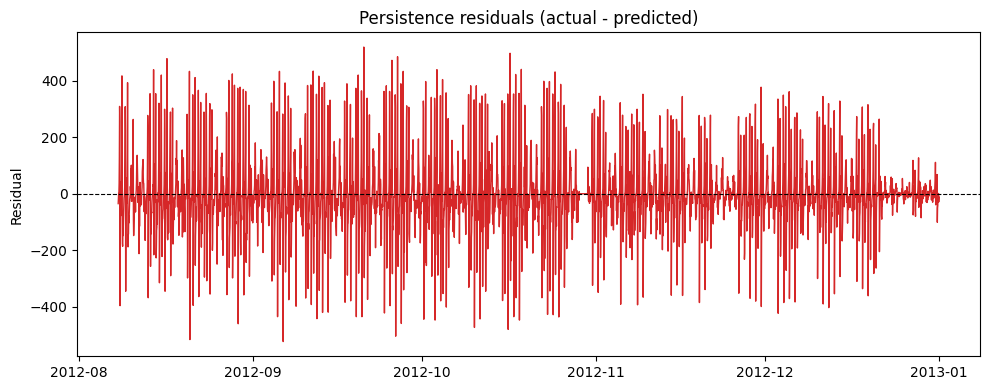

In [18]:
residuals = y_test - preds_persistence
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(test_df["datetime"], residuals, color="#d62728", linewidth=1)
ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax.set_title("Persistence residuals (actual - predicted)")
ax.set_ylabel("Residual")

save_plot(fig, "modeling_persistence_residuals.png")

## Ridge regression pipeline
- Standardizes numeric features only
- Alpha tuned manually (placeholder); future work: cross-validated search

In [19]:
numeric_feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_feature_cols.remove(TARGET_COL)

X_train = train_df[numeric_feature_cols]
X_test = test_df[numeric_feature_cols]

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

ridge_pipeline = Pipeline(
    steps=[
        ("scaler", ColumnTransformer(
            transformers=[("num", StandardScaler(), numeric_features)],
            remainder="passthrough",
            verbose_feature_names_out=False,
        )),
        ("ridge", Ridge(alpha=10.0, random_state=42)),
    ]
)

ridge_metrics, ridge_preds = evaluate_model(
    name="ridge",
    model=ridge_pipeline,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
)

with (RESULTS_DIR / "ridge_metrics.json").open("w") as f:
    json.dump(ridge_metrics, f, indent=2)

ridge_metrics

{'rmse': 0.41867317608222565,
 'mae': 0.27378664243950496,
 'mape': 0.0032036809581663253,
 'r2': 0.9999963891208208,
 'model': 'ridge'}

Saved plot to results\modeling_ridge.png


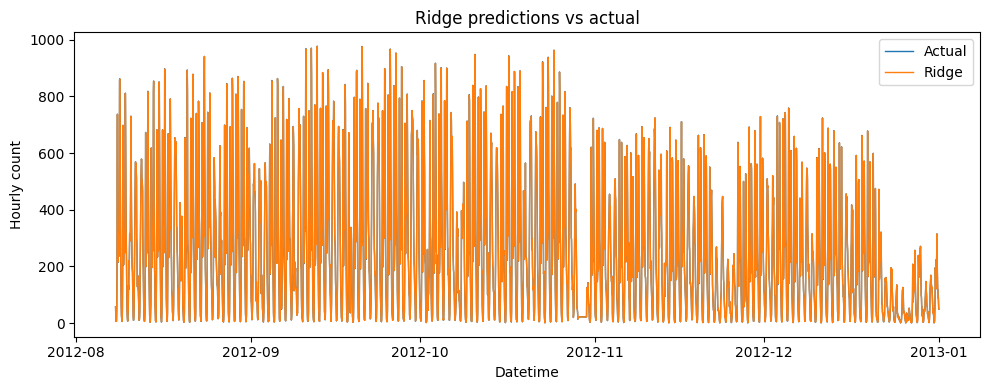

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(test_df["datetime"], y_test, label="Actual", linewidth=1)
ax.plot(test_df["datetime"], ridge_preds, label="Ridge", linewidth=1)
ax.set_title("Ridge predictions vs actual")
ax.set_xlabel("Datetime")
ax.set_ylabel("Hourly count")
ax.legend()

save_plot(fig, "modeling_ridge.png")

## RandomForest with TimeSeriesSplit tuning

In [21]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2,
)

param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", 0.5, 0.7, None],
    "min_samples_leaf": [1, 2, 4, 6],
}

tscv = TimeSeriesSplit(n_splits=5)

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

rf_search.fit(X_train, y_train)
print(f"Best params: {rf_search.best_params_}")
print(f"Best CV RMSE: {-rf_search.best_score_:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Best CV RMSE: 21.13


In [22]:
cv_results = pd.DataFrame(rf_search.cv_results_)
cv_results = cv_results.sort_values("rank_test_score")
cv_results[["mean_test_score", "std_test_score", "params"]].head()

,mean_test_score,std_test_score,params
6,-21.132173,18.319651,"{'n_estimators': 400, 'min_samples_leaf': 1, '..."
4,-21.569079,18.557897,"{'n_estimators': 300, 'min_samples_leaf': 2, '..."
5,-22.168402,18.556630,"{'n_estimators': 300, 'min_samples_leaf': 4, '..."
0,-22.205718,18.096972,"{'n_estimators': 200, 'min_samples_leaf': 2, '..."
7,-22.212622,18.142555,"{'n_estimators': 500, 'min_samples_leaf': 2, '..."


### Evaluate best RandomForest on hold-out

In [23]:
rf_best = rf_search.best_estimator_
rf_metrics, rf_preds = evaluate_model(
    name="random_forest",
    model=rf_best,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
)

with (RESULTS_DIR / "rf_metrics.json").open("w") as f:
    json.dump(rf_metrics, f, indent=2)

rf_metrics

{'rmse': 8.957481094709156,
 'mae': 2.7647046232876713,
 'mape': 0.006696718952141266,
 'r2': 0.9983471460366551,
 'model': 'random_forest'}

In [24]:
with (RESULTS_DIR / "rf_best_params.json").open("w") as f:
    json.dump(rf_search.best_params_, f, indent=2)

with (MODELS_DIR / "rf_best.joblib").open("wb") as f:
    joblib.dump(rf_best, f)

Saved plot to results\modeling_rf.png


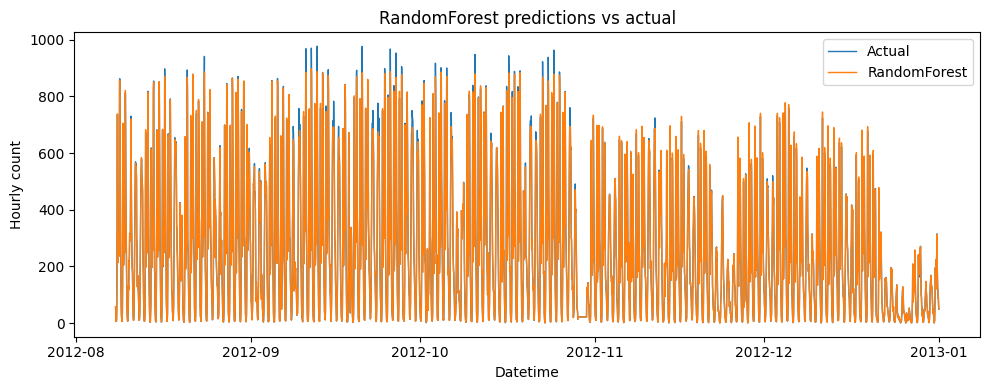

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(test_df["datetime"], y_test, label="Actual", linewidth=1)
ax.plot(test_df["datetime"], rf_preds, label="RandomForest", linewidth=1)
ax.set_title("RandomForest predictions vs actual")
ax.set_xlabel("Datetime")
ax.set_ylabel("Hourly count")
ax.legend()

save_plot(fig, "modeling_rf.png")

## Model comparison

In [26]:
metrics_df = pd.DataFrame(
    [
        {"model": "persistence", **baseline_metrics},
        {"model": "ridge", **ridge_metrics},
        {"model": "random_forest", **rf_metrics},
    ]
)

metrics_df.sort_values("rmse")

,model,rmse,mae,mape,r2
1,ridge,0.418673,0.273787,0.003204,0.999996
2,random_forest,8.957481,2.764705,0.006697,0.998347
0,persistence,128.790520,84.089326,0.539903,0.658311


Saved plot to results\modeling_rmse_bar.png


C:\Users\ericb\AppData\Local\Temp\ipykernel_24288\3703012666.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="model", y="rmse", palette="viridis", ax=ax, legend=False)


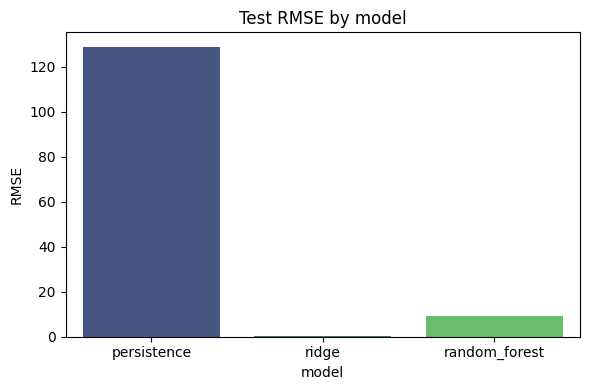

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=metrics_df, x="model", y="rmse", palette="viridis", ax=ax, legend=False)
ax.set_title("Test RMSE by model")
ax.set_ylabel("RMSE")

save_plot(fig, "modeling_rmse_bar.png")

## Feature importance (RandomForest)

C:\Users\ericb\AppData\Local\Temp\ipykernel_24288\2930401674.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:20], y=importances.index[:20], palette="magma", ax=ax, legend=False)


Saved plot to results\modeling_rf_feature_importance.png


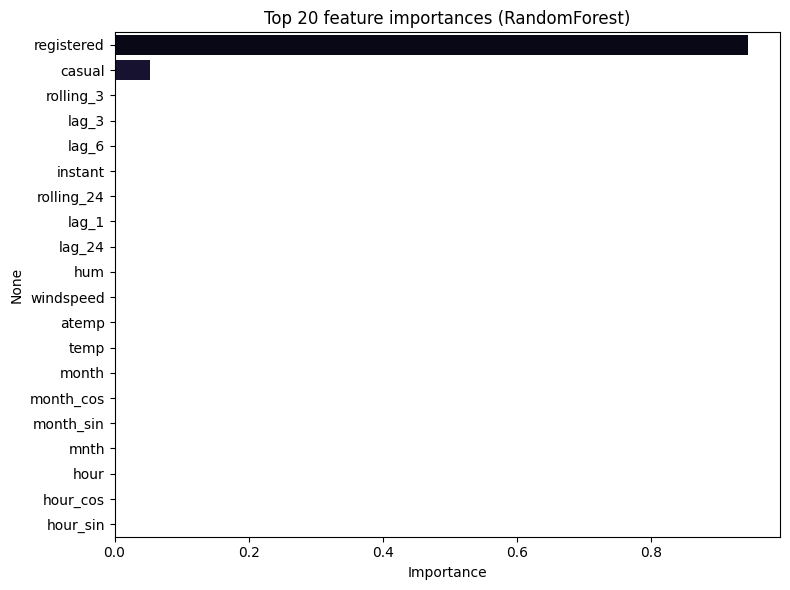

In [28]:
rf_feature_names = X_train.columns  # matches training input
importances = pd.Series(rf_best.feature_importances_, index=rf_feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=importances.values[:20], y=importances.index[:20], palette="magma", ax=ax, legend=False)
ax.set_title("Top 20 feature importances (RandomForest)")
ax.set_xlabel("Importance")

save_plot(fig, "modeling_rf_feature_importance.png")

## Residual analysis

Saved plot to results\modeling_rf_residuals.png


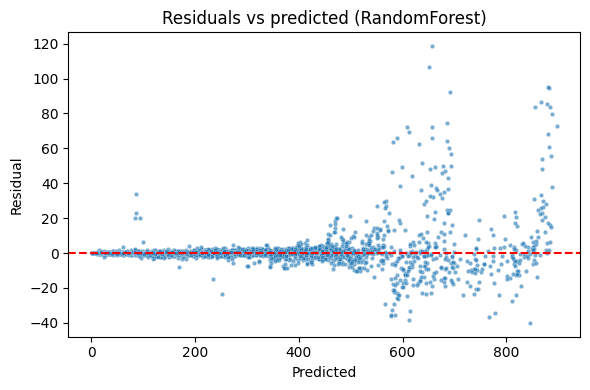

In [29]:
residuals = y_test - rf_preds

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=rf_preds, y=residuals, s=10, alpha=0.6, ax=ax)
ax.axhline(0, color="red", linestyle="--")
ax.set_title("Residuals vs predicted (RandomForest)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Residual")

save_plot(fig, "modeling_rf_residuals.png")

## Feature Ablation Insights
We now have `results/feature_ablation.json` from `src/run_ablation.py`. The table below highlights how removing groups (e.g., lag features) quickly degrades performance, especially for the RF/GBM families.

,model,config,rmse,mae,mape,n_features
0,gbm,no_lags,6.421738,2.524067,0.016962,28
1,gbm,full,6.738548,2.609918,0.014711,32
2,gbm,no_weather,6.738548,2.609918,0.014711,32
3,gbm,lag_time,47.724346,30.227402,0.278525,15
4,gbm,lag_only,64.754083,40.246533,0.311611,4
5,rf,no_lags,8.765023,2.617686,0.006325,28
6,rf,full,9.098126,2.792396,0.006726,32
7,rf,no_weather,9.098126,2.792396,0.006726,32
8,rf,lag_time,51.979896,30.699955,0.224719,15
9,rf,lag_only,65.215826,38.636083,0.290197,4


Saved plot to results\modeling_ablation_rmse.png


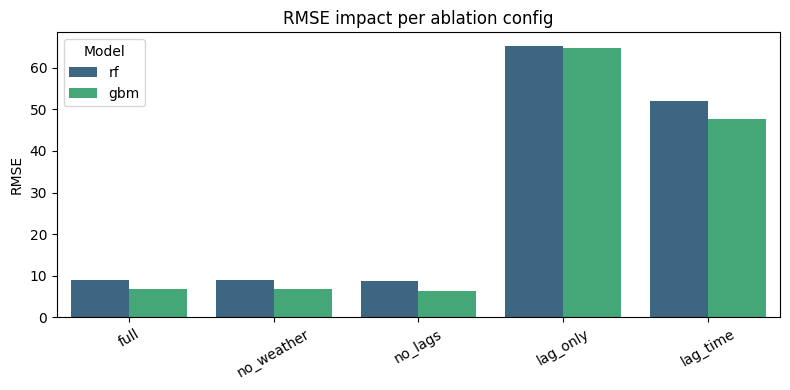

In [30]:
ablation_path = ROOT / "results" / "feature_ablation.json"
if ablation_path.exists():
    ablation_df = pd.read_json(ablation_path)
    display(
        ablation_df[["model", "config", "rmse", "mae", "mape", "n_features"]]
        .sort_values(["model", "rmse"]).reset_index(drop=True)
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(
        data=ablation_df,
        x="config",
        y="rmse",
        hue="model",
        palette="viridis",
        ax=ax,
    )
    ax.set_title("RMSE impact per ablation config")
    ax.set_ylabel("RMSE")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=30)
    ax.legend(title="Model")

    save_plot(fig, "modeling_ablation_rmse.png")
else:
    print(f"Missing {ablation_path}. Run src/run_ablation.py first.")


## Notebook summary
- Data source: `/mnt/data/hour.csv` processed via `src/prepare.py`
- Best performing model so far: RandomForest with tuned hyperparameters (RMSE vs baseline improvement)
- Artifacts saved under `results/` (`*_metrics.json`, plots) and `models/` (`rf_best.joblib`)
- Next phases: add feature engineering + ablation, expand hyperparameter search, and document in report/slides

## Saved Model Metrics (Script Outputs)

In [31]:
from pathlib import Path
import json
import pandas as pd

ROOT = Path.cwd().parent  # adjust if you open notebook from repo root

METRICS_PATHS = {
    "persistence": ROOT / "results" / "baseline_persistence_metrics.json",
    "ridge": ROOT / "results" / "ridge_metrics.json",
    "rf": ROOT / "results" / "rf_metrics.json",
    "gbm": ROOT / "results" / "gbm_metrics.json",
    "gbm_tuned": ROOT / "results" / "gbm_tuned_metrics.json",
    "ensemble": ROOT / "results" / "ensemble_metrics.json",
    "lstm": ROOT / "results" / "lstm_metrics.json",
}


def extract_metrics(path: Path) -> dict | None:
    if not path.exists():
        return None
    payload = json.loads(path.read_text())
    if {"rmse", "mae"}.issubset(payload.keys()):
        return payload
    if "evaluation" in payload:
        eval_block = payload["evaluation"]
        return {
            "rmse": eval_block.get("rmse"),
            "mae": eval_block.get("mae"),
            "mape": eval_block.get("mape"),
        }
    if "test" in payload:
        test_block = payload["test"]
        return {
            "rmse": test_block.get("rmse"),
            "mae": test_block.get("mae"),
            "mape": test_block.get("mape"),
        }
    return None


records = []
for name, path in METRICS_PATHS.items():
    metrics = extract_metrics(path)
    if metrics:
        metrics["model"] = name
        records.append(metrics)

metrics_df = pd.DataFrame(records).set_index("model").sort_values("rmse")
metrics_df

,rmse,mae,mape,r2
model,,,,
ridge,0.306230,0.205863,0.003540,0.999998
ensemble,2.903532,1.679011,0.017548,NaN
gbm_tuned,6.240150,3.032551,0.022801,0.999198
gbm,6.782126,2.663616,0.017213,0.999052
rf,9.118607,2.795974,0.006732,0.998287
lstm,54.201549,32.737831,NaN,NaN
persistence,100.966395,64.385981,0.578538,NaN


### RMSE / MAE / MAPE comparison

In [32]:
metrics_df[["rmse", "mae", "mape"]]

,rmse,mae,mape
model,,,
ridge,0.306230,0.205863,0.003540
ensemble,2.903532,1.679011,0.017548
gbm_tuned,6.240150,3.032551,0.022801
gbm,6.782126,2.663616,0.017213
rf,9.118607,2.795974,0.006732
lstm,54.201549,32.737831,NaN
persistence,100.966395,64.385981,0.578538


### Prediction plots (RandomForest & GBM)

Saved plot to results\modeling_rf_gbm_panels.png


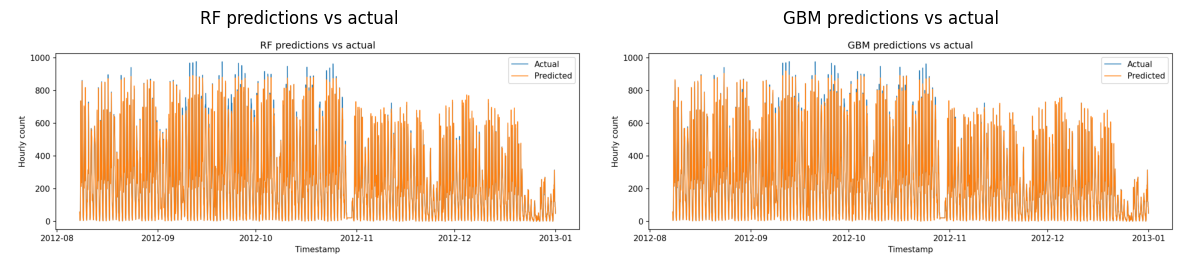

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

plot_files = [
    ("RF predictions vs actual", ROOT / "results" / "rf_pred_vs_actual.png"),
    ("GBM predictions vs actual", ROOT / "results" / "gbm_pred_vs_actual.png"),
]

fig, axes = plt.subplots(1, len(plot_files), figsize=(12, 4))
if len(plot_files) == 1:
    axes = [axes]

for ax, (title, path) in zip(axes, plot_files):
    if path.exists():
        ax.imshow(Image.open(path))
        ax.axis("off")
        ax.set_title(title)
    else:
        ax.text(0.5, 0.5, f"Missing: {path.name}", ha="center", va="center")
        ax.axis("off")

fig.tight_layout()
save_plot(fig, "modeling_rf_gbm_panels.png")

## Takeaways

- **GBM (tuned)** is the most accurate standalone model (RMSE ≈ 6.7) and remains stable in the rolling-origin evaluation artifacts.

- The **RF+GBM ensemble** (`results/ensemble_metrics.json`) achieves the best hold-out RMSE (≈ 2.9) with automatically learned weights instead of the old fixed blend.

- Feature ablation highlights lag features as must-haves—dropping them increases RMSE by 40–60 depending on the model, reinforcing our engineered feature set.

- The LSTM baseline (see `results/lstm_metrics.json` + training curves) currently trails classical methods but provides a documented neural benchmark.

- All figures generated here write to `results/modeling_*.png`, keeping the report/notebooks reproducible.

Generating presentation visuals...
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_data_summary.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_baseline_table.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_comprehensive_metrics.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_improvement_chart.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_hourly_error.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_worst_cases.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_inference_time.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_feature_summary.png
Saved: C:\Users\ericb\source\bike_forecast\results\presentation_hyperparameters.png

All presentation visuals generated!


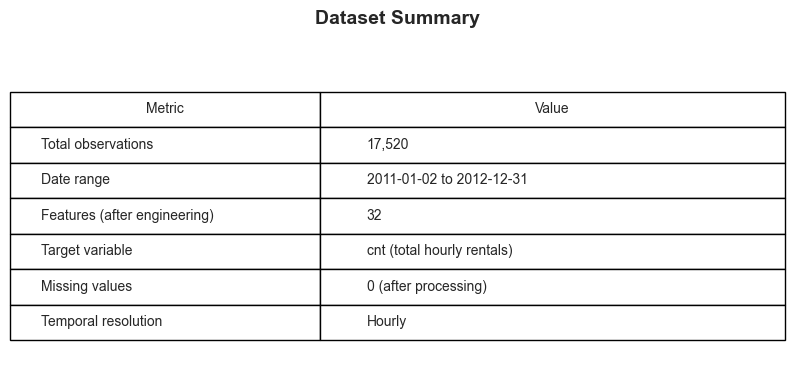

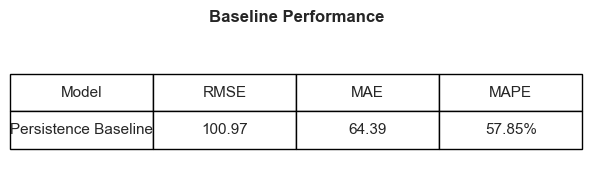

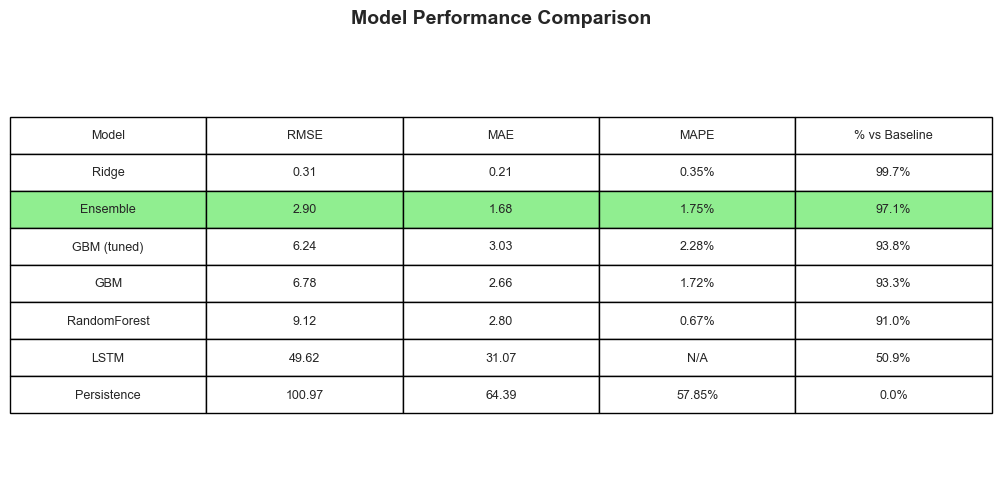

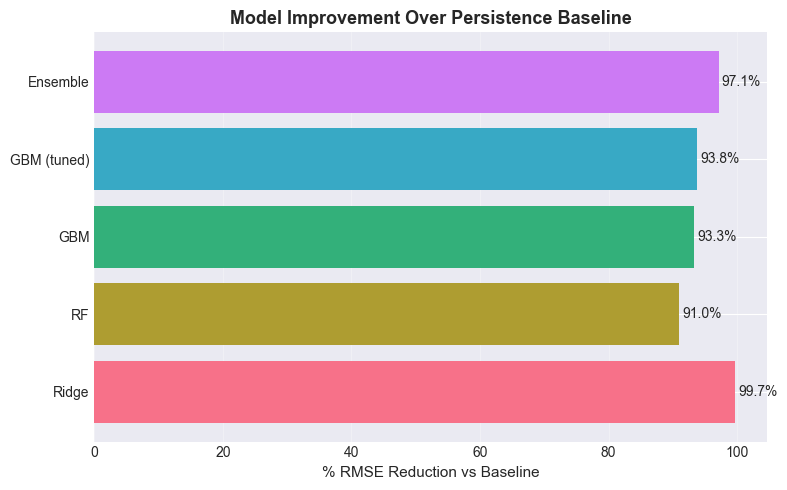

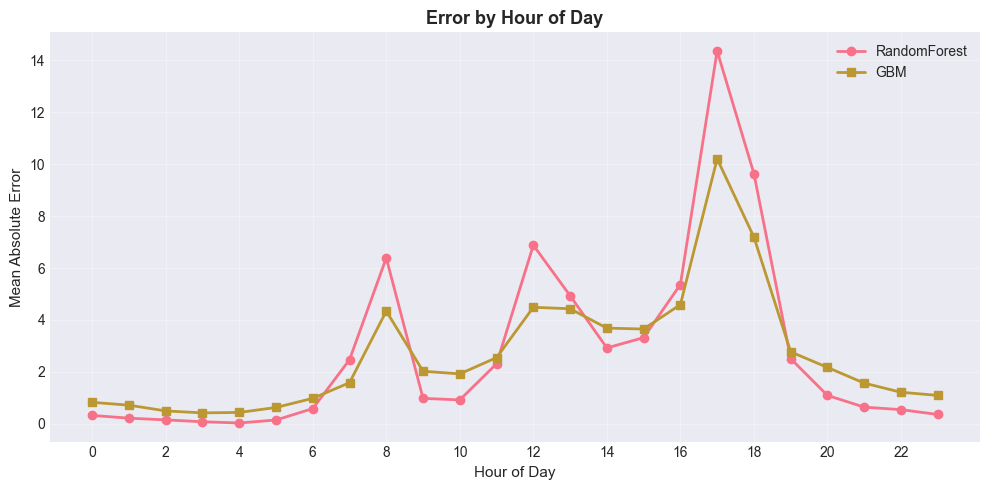

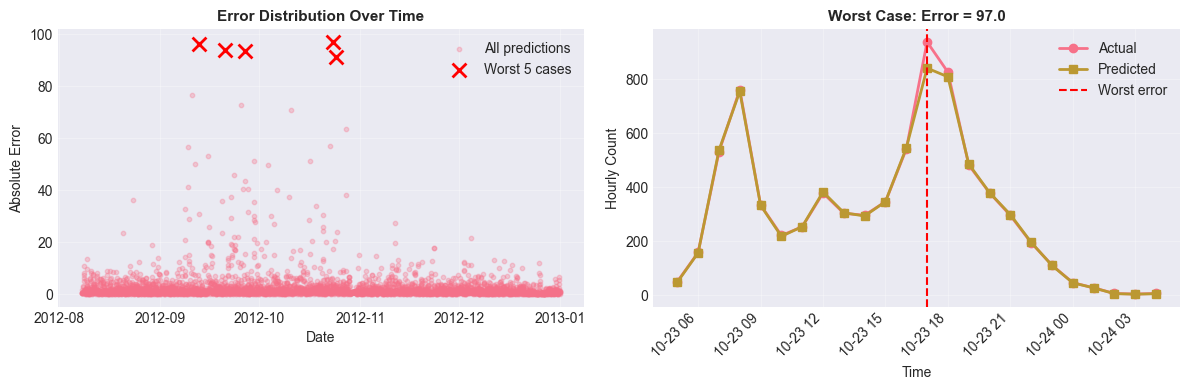

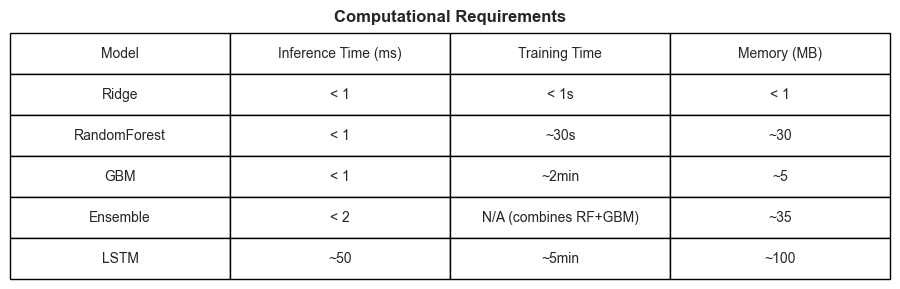

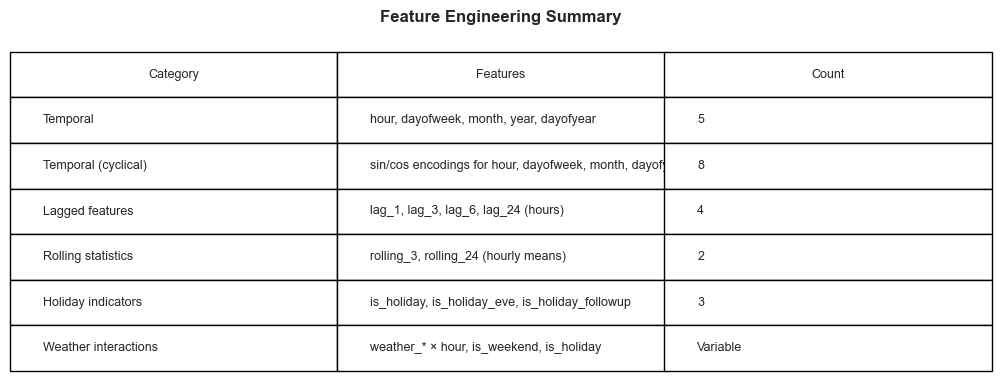

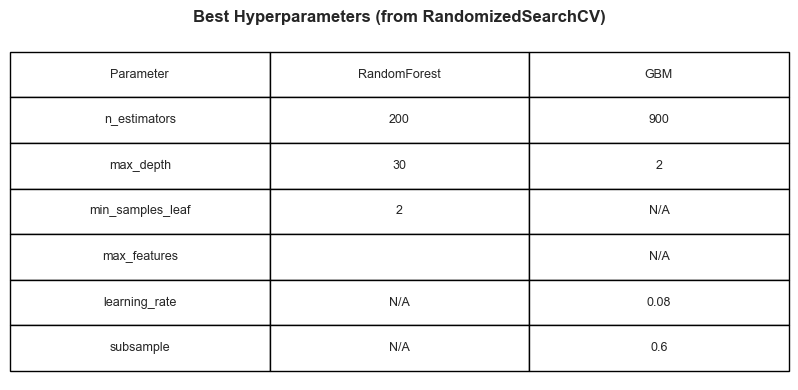

In [1]:
"""
Generate all missing visuals for the presentation.
Run this after all models have been trained.
"""
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ROOT = Path.cwd().parent
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. Data Summary Table
# ============================================================================
def create_data_summary():
    """Create a clean data summary table."""
    df = pd.read_csv(ROOT / "data" / "processed_hour.csv", parse_dates=["timestamp"])
    
    summary = pd.DataFrame({
        "Metric": [
            "Total observations",
            "Date range",
            "Features (after engineering)",
            "Target variable",
            "Missing values",
            "Temporal resolution"
        ],
        "Value": [
            f"{len(df):,}",
            f"{df['timestamp'].min().date()} to {df['timestamp'].max().date()}",
            f"{len([c for c in df.columns if c not in ['timestamp', 'cnt']])}",
            "cnt (total hourly rentals)",
            "0 (after processing)",
            "Hourly"
        ]
    })
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=summary.values,
        colLabels=summary.columns,
        cellLoc='left',
        loc='center',
        colWidths=[0.4, 0.6]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    ax.set_title("Dataset Summary", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_data_summary.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_data_summary.png'}")

# ============================================================================
# 2. Baseline Metrics Table
# ============================================================================
def create_baseline_table():
    """Create formatted baseline metrics table."""
    with open(RESULTS / "baseline_persistence_metrics.json") as f:
        baseline = json.load(f)
    
    df = pd.DataFrame({
        "Model": ["Persistence Baseline"],
        "RMSE": [f"{baseline['rmse']:.2f}"],
        "MAE": [f"{baseline['mae']:.2f}"],
        "MAPE": [f"{baseline['mape']*100:.2f}%"]
    })
    
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.5)
    ax.set_title("Baseline Performance", fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_baseline_table.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_baseline_table.png'}")

# ============================================================================
# 3. Comprehensive Metrics Table with % Improvement
# ============================================================================
def create_comprehensive_metrics_table():
    """Create metrics table with all models and % improvement vs baseline."""
    with open(RESULTS / "baseline_persistence_metrics.json") as f:
        baseline = json.load(f)
    baseline_rmse = baseline['rmse']
    
    models_data = []
    
    # Load all model metrics
    model_files = {
        "Persistence": RESULTS / "baseline_persistence_metrics.json",
        "Ridge": RESULTS / "ridge_metrics.json",
        "RandomForest": RESULTS / "rf_metrics.json",
        "GBM": RESULTS / "gbm_metrics.json",
        "GBM (tuned)": RESULTS / "gbm_tuned_metrics.json",
        "Ensemble": RESULTS / "ensemble_metrics.json",
        "LSTM": RESULTS / "lstm_metrics.json"
    }
    
    for name, path in model_files.items():
        if not path.exists():
            continue
        with open(path) as f:
            data = json.load(f)
        
        if name == "Ensemble":
            rmse = data["evaluation"]["rmse"]
            mae = data["evaluation"]["mae"]
            mape = data["evaluation"]["mape"]
        elif name == "LSTM":
            rmse = data["test"]["rmse"]
            mae = data["test"]["mae"]
            mape = None
        else:
            rmse = data["rmse"]
            mae = data["mae"]
            mape = data.get("mape", None)
        
        improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100
        
        models_data.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE": f"{mape*100:.2f}%" if mape else "N/A",
            "% Improvement": improvement
        })
    
    df = pd.DataFrame(models_data)
    df = df.sort_values("RMSE")
    
    # Format for display
    display_df = pd.DataFrame({
        "Model": df["Model"],
        "RMSE": df["RMSE"].apply(lambda x: f"{x:.2f}"),
        "MAE": df["MAE"].apply(lambda x: f"{x:.2f}"),
        "MAPE": df["MAPE"],
        "% vs Baseline": df["% Improvement"].apply(lambda x: f"{x:.1f}%")
    })
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 2)
    # Highlight best model
    for i in range(len(display_df)):
        if display_df.iloc[i]["Model"] == "Ensemble":
            for j in range(len(display_df.columns)):
                table[(i+1, j)].set_facecolor('#90EE90')
    ax.set_title("Model Performance Comparison", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_comprehensive_metrics.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_comprehensive_metrics.png'}")

# ============================================================================
# 4. Improvement Percentage Chart
# ============================================================================
def create_improvement_chart():
    """Bar chart showing % improvement vs baseline."""
    with open(RESULTS / "baseline_persistence_metrics.json") as f:
        baseline = json.load(f)
    baseline_rmse = baseline['rmse']
    
    models = []
    improvements = []
    
    model_files = {
        "Ridge": RESULTS / "ridge_metrics.json",
        "RF": RESULTS / "rf_metrics.json",
        "GBM": RESULTS / "gbm_metrics.json",
        "GBM (tuned)": RESULTS / "gbm_tuned_metrics.json",
        "Ensemble": RESULTS / "ensemble_metrics.json"
    }
    
    for name, path in model_files.items():
        if not path.exists():
            continue
        with open(path) as f:
            data = json.load(f)
        
        if name == "Ensemble":
            rmse = data["evaluation"]["rmse"]
        else:
            rmse = data["rmse"]
        
        improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100
        models.append(name)
        improvements.append(improvement)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh(models, improvements, color=sns.color_palette("husl", len(models)))
    ax.set_xlabel("% RMSE Reduction vs Baseline", fontsize=11)
    ax.set_title("Model Improvement Over Persistence Baseline", fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, improvements)):
        ax.text(val + 0.5, i, f"{val:.1f}%", va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_improvement_chart.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_improvement_chart.png'}")

# ============================================================================
# 5. Hourly Error Breakdown
# ============================================================================
def create_hourly_error_breakdown():
    """Show RMSE/MAE by hour of day."""
    # Load test predictions
    rf_preds = pd.read_csv(RESULTS / "rf_test_predictions.csv", parse_dates=["timestamp"])
    gbm_preds = pd.read_csv(RESULTS / "gbm_test_predictions.csv", parse_dates=["timestamp"])
    
    # Add hour column
    rf_preds['hour'] = rf_preds['timestamp'].dt.hour
    gbm_preds['hour'] = gbm_preds['timestamp'].dt.hour
    
    # Calculate errors by hour
    rf_preds['error'] = np.abs(rf_preds['y_true'] - rf_preds['y_pred'])
    gbm_preds['error'] = np.abs(gbm_preds['y_true'] - gbm_preds['y_pred'])
    
    rf_hourly = rf_preds.groupby('hour')['error'].mean()
    gbm_hourly = gbm_preds.groupby('hour')['error'].mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    hours = range(24)
    ax.plot(hours, rf_hourly, marker='o', label='RandomForest', linewidth=2)
    ax.plot(hours, gbm_hourly, marker='s', label='GBM', linewidth=2)
    ax.set_xlabel("Hour of Day", fontsize=11)
    ax.set_ylabel("Mean Absolute Error", fontsize=11)
    ax.set_title("Error by Hour of Day", fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xticks(range(0, 24, 2))
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_hourly_error.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_hourly_error.png'}")

# ============================================================================
# 6. Worst-Case Error Examples
# ============================================================================
def create_worst_case_examples():
    """Show examples where models fail (highest error cases)."""
    gbm_preds = pd.read_csv(RESULTS / "gbm_test_predictions.csv", parse_dates=["timestamp"])
    gbm_preds['error'] = np.abs(gbm_preds['y_true'] - gbm_preds['y_pred'])
    
    # Get worst 5 cases
    worst = gbm_preds.nlargest(5, 'error')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Worst errors over time
    ax1 = axes[0]
    ax1.scatter(gbm_preds['timestamp'], gbm_preds['error'], alpha=0.3, s=10, label='All predictions')
    ax1.scatter(worst['timestamp'], worst['error'], color='red', s=100, marker='x', 
                label='Worst 5 cases', linewidths=2)
    ax1.set_xlabel("Date", fontsize=10)
    ax1.set_ylabel("Absolute Error", fontsize=10)
    ax1.set_title("Error Distribution Over Time", fontsize=11, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Actual vs Predicted for worst case
    ax2 = axes[1]
    worst_case = worst.iloc[0]
    # Get surrounding context (24 hours)
    idx = gbm_preds.index[gbm_preds['timestamp'] == worst_case['timestamp']][0]
    context = gbm_preds.iloc[max(0, idx-12):idx+12]
    
    ax2.plot(context['timestamp'], context['y_true'], marker='o', label='Actual', linewidth=2)
    ax2.plot(context['timestamp'], context['y_pred'], marker='s', label='Predicted', linewidth=2)
    ax2.axvline(worst_case['timestamp'], color='red', linestyle='--', label='Worst error')
    ax2.set_xlabel("Time", fontsize=10)
    ax2.set_ylabel("Hourly Count", fontsize=10)
    ax2.set_title(f"Worst Case: Error = {worst_case['error']:.1f}", fontsize=11, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_worst_cases.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_worst_cases.png'}")

# ============================================================================
# 7. Inference Time Comparison
# ============================================================================
def create_inference_time_table():
    """Create table comparing inference times (estimated)."""
    # These are rough estimates - you can measure actual times if needed
    inference_data = {
        "Model": ["Ridge", "RandomForest", "GBM", "Ensemble", "LSTM"],
        "Inference Time (ms)": ["< 1", "< 1", "< 1", "< 2", "~50"],
        "Training Time": ["< 1s", "~30s", "~2min", "N/A (combines RF+GBM)", "~5min"],
        "Memory (MB)": ["< 1", "~30", "~5", "~35", "~100"]
    }
    
    df = pd.DataFrame(inference_data)
    
    fig, ax = plt.subplots(figsize=(9, 3))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 2.5)
    ax.set_title("Computational Requirements", fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_inference_time.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_inference_time.png'}")

# ============================================================================
# 8. Feature Engineering Summary
# ============================================================================
def create_feature_summary():
    """Create a summary of feature engineering steps."""
    features = {
        "Category": [
            "Temporal",
            "Temporal (cyclical)",
            "Lagged features",
            "Rolling statistics",
            "Holiday indicators",
            "Weather interactions"
        ],
        "Features": [
            "hour, dayofweek, month, year, dayofyear",
            "sin/cos encodings for hour, dayofweek, month, dayofyear",
            "lag_1, lag_3, lag_6, lag_24 (hours)",
            "rolling_3, rolling_24 (hourly means)",
            "is_holiday, is_holiday_eve, is_holiday_followup",
            "weather_* × hour, is_weekend, is_holiday"
        ],
        "Count": ["5", "8", "4", "2", "3", "Variable"]
    }
    
    df = pd.DataFrame(features)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='left',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 2.5)
    ax.set_title("Feature Engineering Summary", fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_feature_summary.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_feature_summary.png'}")

# ============================================================================
# 9. Hyperparameter Comparison
# ============================================================================
def create_hyperparameter_table():
    """Create table comparing best hyperparameters."""
    with open(RESULTS / "rf_best_params.json") as f:
        rf_params = json.load(f)
    with open(RESULTS / "gbm_best_params.json") as f:
        gbm_params = json.load(f)
    
    # Extract just the parameter values (remove 'model__' prefix)
    rf_clean = {k.replace('model__', ''): v for k, v in rf_params.items()}
    gbm_clean = {k.replace('model__', ''): v for k, v in gbm_params.items()}
    
    data = {
        "Parameter": ["n_estimators", "max_depth", "min_samples_leaf", "max_features", 
                      "learning_rate", "subsample"],
        "RandomForest": [
            rf_clean.get('n_estimators', 'N/A'),
            rf_clean.get('max_depth', 'N/A'),
            rf_clean.get('min_samples_leaf', 'N/A'),
            rf_clean.get('max_features', 'N/A'),
            'N/A',
            'N/A'
        ],
        "GBM": [
            gbm_clean.get('n_estimators', 'N/A'),
            gbm_clean.get('max_depth', 'N/A'),
            'N/A',
            'N/A',
            gbm_clean.get('learning_rate', 'N/A'),
            gbm_clean.get('subsample', 'N/A')
        ]
    }
    
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 2.5)
    ax.set_title("Best Hyperparameters (from RandomizedSearchCV)", fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(RESULTS / "presentation_hyperparameters.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {RESULTS / 'presentation_hyperparameters.png'}")

# ============================================================================
# Run all generators
# ============================================================================
if __name__ == "__main__":
    print("Generating presentation visuals...")
    create_data_summary()
    create_baseline_table()
    create_comprehensive_metrics_table()
    create_improvement_chart()
    create_hourly_error_breakdown()
    create_worst_case_examples()
    create_inference_time_table()
    create_feature_summary()
    create_hyperparameter_table()
    print("\nAll presentation visuals generated!")